In [793]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [629]:
%autoreload
import copy
import sys
from collections import OrderedDict

import matplotlib.pyplot as plt
import numpy as np
from scipy import ndimage
from scipy.optimize import curve_fit
from skimage import filters
from tqdm.auto import tqdm

sys.path.append("/scratch/gpfs/js5013/programs/cfilt/")
from cfilt.utils import *

In [1229]:
ds = CDS(
    [1, 4, 16, 1600],
    "jx",
    "../out/",
    normalize=True,
)

  0%|          | 0/4 [00:00<?, ?it/s]

In [1100]:
crop = lambda x: x[3:-1, 3:-2]

In [1256]:
im = crop(ds.images[4][10])

In [1231]:
def gaussian_kernel_1d(sigma):
    kernel_radius = np.ceil(sigma) * 3
    kernel_size = kernel_radius * 2 + 1
    ax = np.arange(-kernel_radius, kernel_radius + 1.0, dtype=np.float32)
    kernel = np.exp(-(ax**2) / (2.0 * sigma**2))
    return kernel / np.sum(kernel)

In [1232]:
def gaussian_kernel_2d(sigma):
    kernel_radius = int(sigma * 3)
    kernel_size = kernel_radius * 2 + 1
    ax = np.arange(-kernel_radius, kernel_radius + 1.0, dtype=np.float32)
    xx, yy = np.meshgrid(ax, ax)
    kernel = np.exp(-(xx**2 + yy**2) / (2.0 * sigma**2))
    return kernel / np.sum(kernel)

In [1233]:
def filter_wrapper(
    x, grad_fn, stat_fn, sigma_fn=None, filter_fn=None, return_stat=False
):
    n = int(np.sqrt(x.size))
    mid = n // 2
    chunk = x.reshape(n, n)
    grad = grad_fn(chunk)
    stat = stat_fn(grad)
    if sigma_fn:
        sigma = sigma_fn(stat)
    if return_stat:
        return stat
    return filter_fn(chunk, sigma)[mid, mid]

In [1234]:
def ecdf(x):
    xs = np.sort(x)
    ys = np.arange(1, len(xs) + 1) / float(len(xs))
    return xs, ys

In [1283]:
stat = ndimage.generic_filter(
    im,
    filter_wrapper,
    size=5,
    extra_keywords=dict(
        # filter_fn=lambda chunk, sigma:
        # grad_fn=lambda chunk: ndimage.sobel(np.exp(chunk)),
        grad_fn=lambda chunk: ndimage.sobel(np.exp(chunk)),
        stat_fn=lambda grad: np.log(np.max(grad) - np.min(grad)) + np.log(np.std(grad)),
        # grad_fn=lambda chunk: ndimage.gaussian_gradient_magnitude(
        #     np.exp(chunk), sigma=5
        # ),
        # stat_fn=lambda g: np.log(g.mean()),
        return_stat=True,
    ),
)

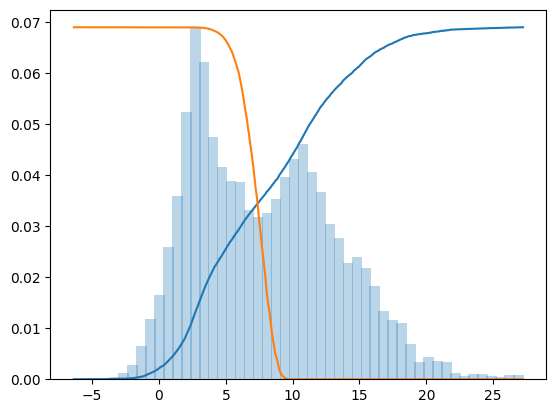

In [1352]:
sstat = np.ravel(stat)
counts, edges = np.histogram(sstat[np.isfinite(sstat)], bins="auto")
counts = counts / counts.sum()
edges = (edges[:-1] + edges[1:]) / 2

gx, gy = ecdf(sstat)
plt.bar(edges, counts, alpha=0.3)
plt.plot(gx, gy * counts.max())
gym = np.exp(-2 * (gy + 0.45) ** 20)
gymn = gym / gym.max()
plt.plot(gx, gymn * counts.max())

In [1353]:
out1 = ndimage.generic_filter(
    im,
    filter_wrapper,
    size=5,
    extra_keywords=dict(
        grad_fn=lambda chunk: ndimage.sobel(np.exp(chunk)),
        stat_fn=lambda grad: np.log(np.max(grad) - np.min(grad)) + np.log(np.std(grad)),
        # grad_fn=lambda chunk: ndimage.gaussian_gradient_magnitude(
        #     np.exp(chunk), sigma=5
        # ),
        # stat_fn=lambda grad: np.log(np.mean(grad)),
        sigma_fn=lambda stat: np.interp(stat, gx, gymn),
        filter_fn=lambda chunk, sigma: ndimage.gaussian_filter(
            chunk, sigma=sigma, truncate=5
        ),
        return_stat=False,
    ),
)
out2 = ndimage.generic_filter(
    -im,
    filter_wrapper,
    size=5,
    extra_keywords=dict(
        grad_fn=lambda chunk: ndimage.sobel(np.exp(chunk)),
        stat_fn=lambda grad: np.log(np.max(grad) - np.min(grad)) + np.log(np.std(grad)),
        # grad_fn=lambda chunk: ndimage.gaussian_gradient_magnitude(
        #     np.exp(chunk), sigma=5
        # ),
        # stat_fn=lambda grad: np.log(np.mean(grad)),
        sigma_fn=lambda stat: np.interp(stat, gx, gymn),
        filter_fn=lambda chunk, sigma: ndimage.gaussian_filter(
            chunk, sigma=sigma, truncate=5
        ),
        return_stat=False,
    ),
)
outt = np.zeros_like(out1)
outt[out1 > 0] = out1[out1 > 0]
outt[out2 > 0] = -out2[out2 > 0]
msk = ~((out1 > 0) | (out2 > 0))
out[msk] = (out1[msk] + out2[msk]) / 2

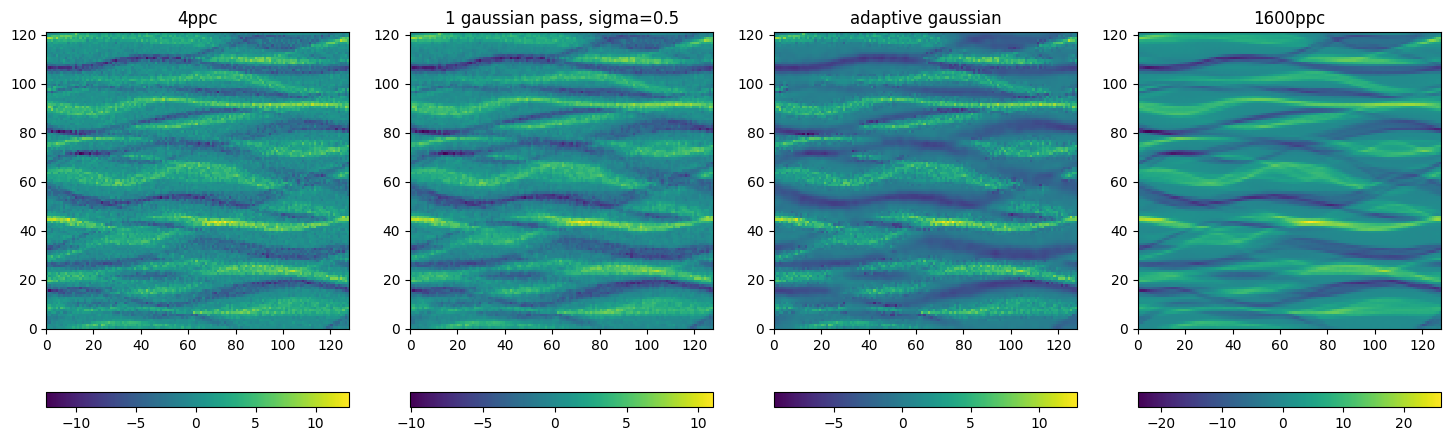

In [1354]:
fig, ax = plt.subplots(1, 4, figsize=(18, 5.5))
a0 = ax[0].pcolormesh(im)
a1 = ax[1].pcolormesh(ndimage.gaussian_filter(im, sigma=0.5))
a2 = ax[2].pcolormesh(out1)
a3 = ax[3].pcolormesh(crop(ds.images[1600][10]))
ax[0].set_title("4ppc")
ax[1].set_title("1 gaussian pass, sigma=0.5")
ax[2].set_title("adaptive gaussian")
ax[3].set_title("1600ppc")
plt.colorbar(a0, ax=ax[0], location="bottom")
plt.colorbar(a1, ax=ax[1], location="bottom")
plt.colorbar(a2, ax=ax[2], location="bottom")
plt.colorbar(a3, ax=ax[3], location="bottom")

In [898]:
# -*- coding: utf-8 -*-

"""
Two-dimensional Savitzky-Golay filter

"""

import collections
import typing as t

import numpy as np
import numpy.linalg as la
import scipy.ndimage as ndim

Param2 = collections.namedtuple("Param2", ("row", "column"))
Polynom2 = collections.namedtuple("Polynom2", ("row_pows", "column_pows", "num_coeffs"))

_Param2Type = t.Union[Param2, t.Tuple[int, int]]
_ParamType = t.Union[int, _Param2Type]

_DIM = 2


class SGolayKernel2:
    """Computes two-dimensional kernel (weights) for Savitzky-Golay filter"""

    def __init__(self, window_size: _Param2Type, poly_order: _Param2Type):
        self._window_size = Param2(*window_size)
        self._poly_order = Param2(*poly_order)

        self._kernel = None  # type: np.ndarray
        self.computed = False

    def __call__(self):
        self.compute()

    def compute(self):
        if self.computed:
            return

        polynom = self._make_polynom(self._poly_order)
        basis_matrix = self._make_basis_matrix(self._window_size, polynom)

        self._kernel = self._compute_kernel(self._window_size, basis_matrix)

        self.computed = True

    @property
    def kernel(self) -> np.ndarray:
        """Returns 2D Savitzky-Golay kernel"""
        self.compute()
        return self._kernel

    @staticmethod
    def _make_polynom(poly_order: Param2) -> Polynom2:
        """
        Creates 2-D polynom model (for example poly33):
            p = a00 + a10x + a01y + a20x^2 + a11xy + a02y^2 + a30x^3 + a21x^2y \
                + a12xy^2 + a03y^3
        """
        row_pows = []
        column_pows = []
        num_coeffs = 0

        for row in range(poly_order.row + 1):
            for column in range(poly_order.column + 1):
                if (row + column) > max(*poly_order):
                    continue

                row_pows.append(row)
                column_pows.append(column)

                num_coeffs += 1

        return Polynom2(row_pows, column_pows, num_coeffs)

    @staticmethod
    def _make_basis_matrix(window_size: Param2, poly: Polynom2) -> np.ndarray:
        """Creates basis polynomial matrix"""
        basis_rows = window_size.row * window_size.column
        basis_columns = poly.num_coeffs

        basis_matrix = np.zeros((basis_rows, basis_columns))

        radius_row = (window_size.row - 1) // 2
        radius_column = (window_size.column - 1) // 2

        row_pows = np.array(poly.row_pows)
        column_pows = np.array(poly.column_pows)

        k = 0

        for row in range(-radius_row, radius_row + 1):
            for column in range(-radius_column, radius_column + 1):
                basis_matrix[k, :] = column**column_pows * row**row_pows
                k += 1

        return basis_matrix

    @staticmethod
    def _compute_kernel(window_size: Param2, basis_matrix: np.ndarray) -> np.ndarray:
        """Computes filter 2D kernel via solving least squares problem"""
        q, _ = la.qr(basis_matrix)

        iq = (window_size.row * window_size.column - 1) // 2
        kernel = q @ np.array(q[iq, :], ndmin=2).T
        kernel = np.fliplr(kernel.reshape(*window_size, order="F"))

        return kernel


class SGolayFilter2:
    """Two-dimensional Savitzky-Golay filter"""

    def __init__(self, window_size: _ParamType, poly_order: _ParamType):
        self._window_size = self._canonize_param(
            "window_size", window_size, self._validate_window_size
        )
        self._poly_order = self._canonize_param(
            "poly_order", poly_order, self._validate_poly_order
        )

        self._kernel = SGolayKernel2(self._window_size, self._poly_order)

    def __call__(self, data: np.ndarray, mode: str = "reflect", cval: float = 0.0):
        return self._filtrate(data, mode=mode, cval=cval)

    @property
    def window_size(self) -> Param2:
        return self._window_size

    @property
    def poly_order(self) -> Param2:
        return self._poly_order

    @property
    def kernel(self) -> SGolayKernel2:
        """Returns filter 2D kernel"""
        return self._kernel

    @staticmethod
    def _canonize_param(name, value: _ParamType, validator) -> Param2:
        err = TypeError(
            'The parameter "{}" must be int scalar or Tuple[int, int]'.format(name)
        )

        if isinstance(value, int):
            value = (value, value)

        if not isinstance(value, (list, tuple)):
            raise err
        if len(value) != _DIM:
            raise err
        if not all(isinstance(v, int) for v in value):
            raise err

        validator(value)

        return Param2(*value)

    @staticmethod
    def _validate_window_size(value):
        if not all(v >= 3 and bool(v % 2) for v in value):
            raise ValueError(
                "Window size values must be odd and >= 3 (Given: {})".format(value)
            )

    @staticmethod
    def _validate_poly_order(value):
        if not all(v >= 1 for v in value):
            raise ValueError(
                "Polynom order values must be >= 1 (Given: {})".format(value)
            )

    def _filtrate(self, data: np.ndarray, *args, **kwargs):
        self._kernel.compute()
        return ndim.correlate(data, self._kernel.kernel, *args, **kwargs)

In [1359]:
xx, yy = np.meshgrid(np.arange(133), np.arange(125))
xx = crop(xx)
yy = crop(yy)

In [1374]:
sgim = SGolayFilter2(window_size=21, poly_order=11)(im)

Text(0.5, 1.0, '1600ppc')

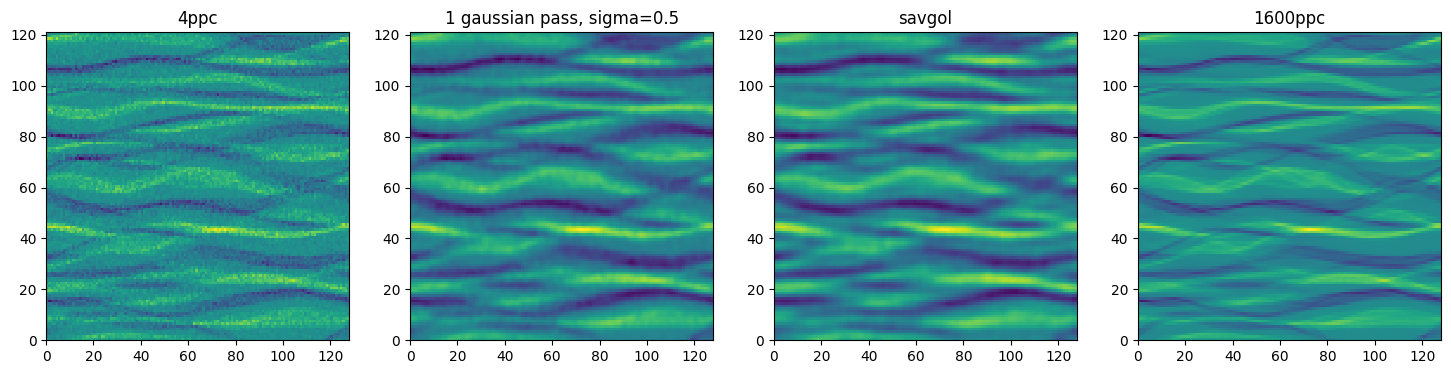

In [1376]:
# plt.pcolormesh(xx, yy, im)

fig, ax = plt.subplots(1, 4, figsize=(18, 4))
ax[0].pcolormesh(im)
ax[1].pcolormesh(ndimage.gaussian_filter(im, sigma=1))
ax[2].pcolormesh(sgim)
ax[3].pcolormesh(crop(ds.images[1600][10]))
ax[0].set_title("4ppc")
ax[1].set_title("1 gaussian pass, sigma=0.5")
ax[2].set_title("savgol")
ax[3].set_title("1600ppc")